### Income Classification on the Adult Census Dataset

In [ ]:
!pip install ucimlrepo
!pip install xgboost

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import requests
from io import StringIO

import warnings
warnings.filterwarnings('ignore')

from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
  
# fetch dataset 
adult = fetch_ucirepo(id=2) 
  
# data (as pandas dataframes) 
X = adult.data.features 
y = adult.data.targets 
  
# metadata 
print(adult.metadata) 
  
# variable information 
print(adult.variables) 

{'uci_id': 2, 'name': 'Adult', 'repository_url': 'https://archive.ics.uci.edu/dataset/2/adult', 'data_url': 'https://archive.ics.uci.edu/static/public/2/data.csv', 'abstract': 'Predict whether annual income of an individual exceeds $50K/yr based on census data. Also known as "Census Income" dataset. ', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 48842, 'num_features': 14, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Income', 'Education Level', 'Other', 'Race', 'Sex'], 'target_col': ['income'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1996, 'last_updated': 'Tue Sep 24 2024', 'dataset_doi': '10.24432/C5XW20', 'creators': ['Barry Becker', 'Ronny Kohavi'], 'intro_paper': None, 'additional_info': {'summary': "Extraction was done by Barry Becker from the 1994 Census database.  A set of reasonably clean records was extracted using the fol

In [ ]:
# Create new dataframe with all features and the target
df = X.copy()
df['income'] = y # add target

# Change '>50K.' to '>50K' and '<=50K.' to '<=50K.'
df['income'] = df['income'].str.replace('.', '', regex=False)
print(df['income'].unique())

['<=50K' '>50K']


In [ ]:
# Filter data to get people earning >50K
df_above_50 = df[df['income'] == '>50K']

# Compute the # of people earning >50K for each sex
above_50_sex = df_above_50['sex'].value_counts()

# Compute total # of people for each category in the sex column (male/female)
# value_counts counts the occurrences of each unique value in the sex column
total_sex = df['sex'].value_counts()

# Compute % of people earning >50K for each sex
percentage_above_50_sex = (above_50_sex / total_sex) * 100
print(percentage_above_50_sex)

sex
Male      30.376723
Female    10.925148
Name: count, dtype: float64


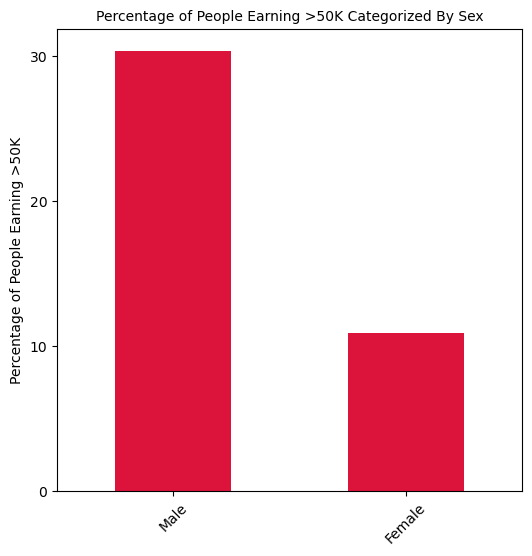

In [ ]:
# Plotting
plt.figure(figsize=(6, 6))

percentage_above_50_sex.plot(kind='bar', color='crimson')
plt.xlabel('')
plt.ylabel('Percentage of People Earning >50K')
plt.yticks(np.arange(0, 40, 10))
plt.title('Percentage of People Earning >50K Categorized By Sex', fontsize=10)
plt.xticks(rotation=45)

plt.show()

In [ ]:
# Create groups of all the combinations of age and income
age_income_groups = df.groupby(['age', 'income'])

# Count the size of each group and put it in a new dataframe 
age_income_group_counts = age_income_groups.size().unstack(fill_value=0)

# Compute total # of people for each age across all incomes
age_count = age_income_group_counts.sum(axis=1)

# Compute % of people earning >50K
age_income_percentage = (age_income_group_counts['>50K'] / age_count) * 100

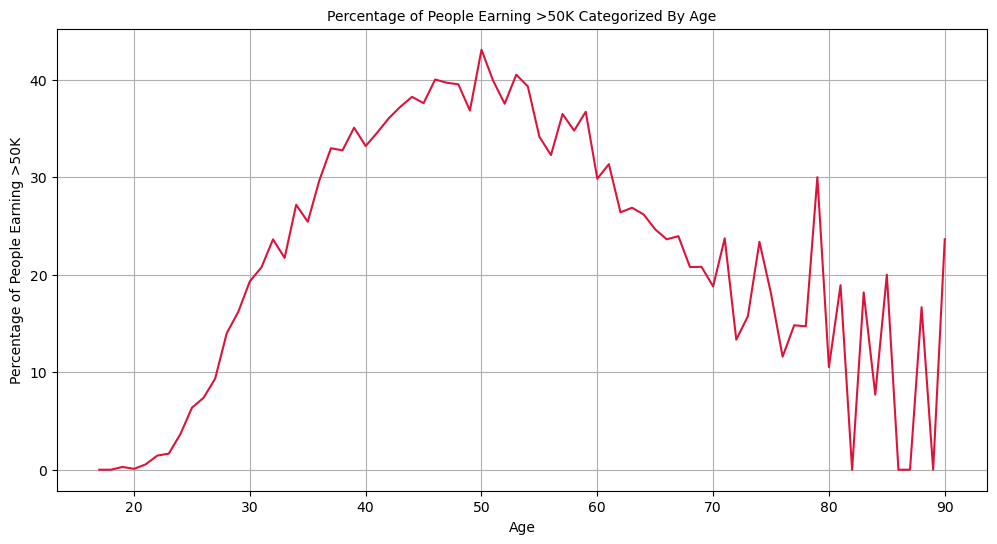

In [ ]:
# Plotting
plt.figure(figsize=(12, 6))

age_list = sorted(df['age'].unique())
ages = [i for i in range(age_list[0], age_list[-1] + 1)]

plt.plot(ages, age_income_percentage, color='crimson')
plt.xlabel('Age')
plt.ylabel('Percentage of People Earning >50K')
plt.yticks(np.arange(0, 50, 10))
plt.title('Percentage of People Earning >50K Categorized By Age', fontsize=10)
plt.grid(True)

plt.show()

In [ ]:
# Filter data to get people earning >50K
df_above_50 = df[df['income'] == '>50K']

# Compute the # of people earning >50K for each education
above_50_edu = df_above_50['education'].value_counts()

# Compute total # of people for each category in the education column
total_edu = df['education'].value_counts()

# Compute % of people earning >50K for each education
percentage_above_50_edu = (above_50_edu / total_edu) * 100
print(percentage_above_50_edu)

education
10th             6.263499
11th             5.077263
12th             7.305936
1st-4th          3.238866
5th-6th          5.304519
7th-8th          6.492147
9th              5.423280
Assoc-acdm      25.796377
Assoc-voc       25.327511
Bachelors       41.283489
Doctorate       72.558923
HS-grad         15.857831
Masters         54.911554
Preschool        1.204819
Prof-school     73.980815
Some-college    18.964883
Name: count, dtype: float64


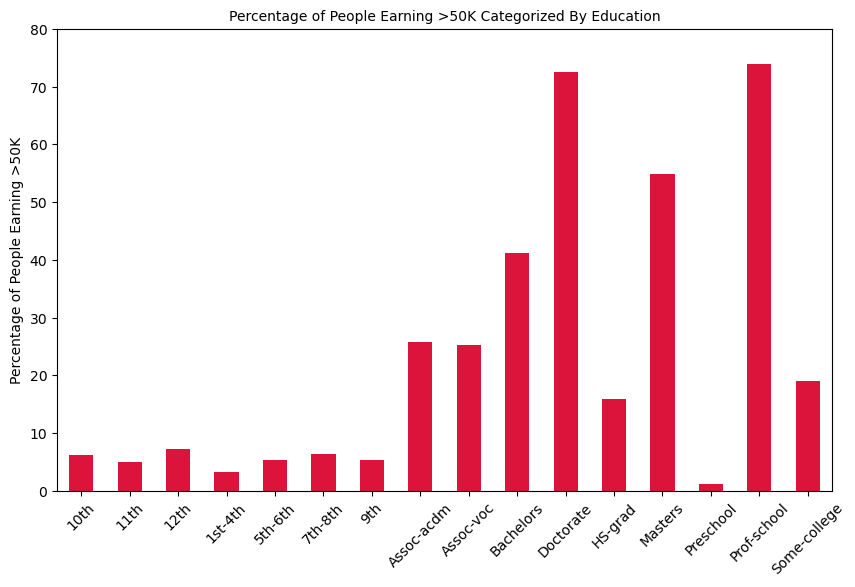

In [ ]:
# Plotting
plt.figure(figsize=(10, 6))

percentage_above_50_edu.plot(kind='bar', color='crimson')
plt.xlabel('')
plt.ylabel('Percentage of People Earning >50K')
plt.yticks(np.arange(0, 90, 10))
plt.title('Percentage of People Earning >50K Categorized By Education', fontsize=10)
plt.xticks(rotation=45)

plt.show()

In [ ]:
# Filter out data where occupation is marked as '?' or nan
filtered_df = df[(df['occupation'] != '?') & df['occupation'].notna()]

# Compute the frequency of each occupation for both '<=50K' and '>50K'
occupation_income_freq = filtered_df.groupby(['occupation', 'income']).size().unstack()
print(occupation_income_freq)

income             <=50K  >50K
occupation                    
Adm-clerical        4843   768
Armed-Forces          10     5
Craft-repair        4729  1383
Exec-managerial     3178  2908
Farming-fishing     1317   173
Handlers-cleaners   1934   138
Machine-op-inspct   2650   372
Other-service       4719   204
Priv-house-serv      239     3
Prof-specialty      3388  2784
Protective-serv      675   308
Sales               4029  1475
Tech-support        1026   420
Transport-moving    1874   481


<Figure size 1200x800 with 0 Axes>

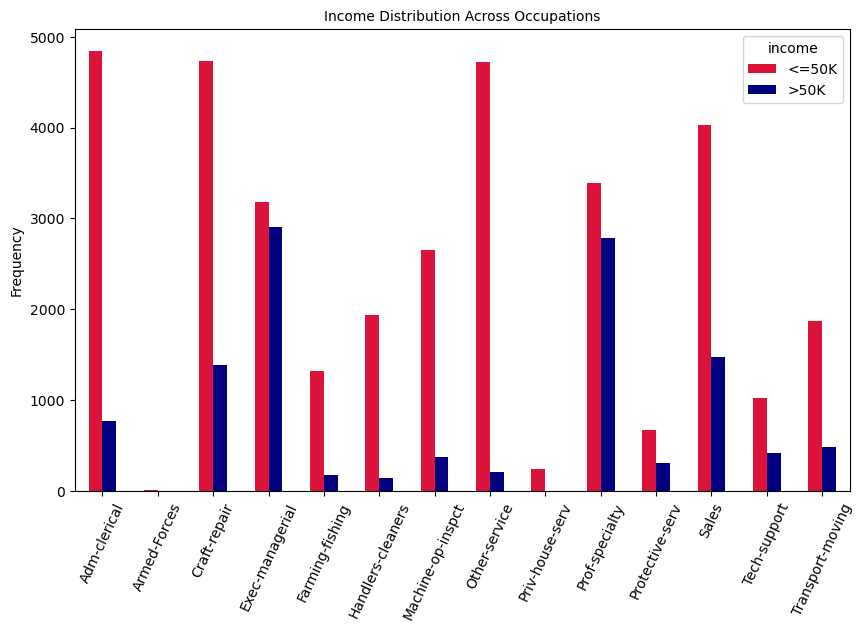

In [ ]:
# Plotting
plt.figure(figsize=(12, 8))

occupation_income_freq.plot(kind='bar', stacked=False, figsize=(10,6), color=['crimson', 'navy'], width=0.5, align='center')
plt.xlabel('')
plt.ylabel('Frequency')
plt.title('Income Distribution Across Occupations', fontsize=10)
plt.xticks(rotation=65)

plt.show()

In [ ]:
df2 = X.copy()
df2['income'] = y # add target

# Change '>50K.' to '>50K' and '<=50K.' to '<=50K.'
df2['income'] = df2['income'].str.replace('.', '', regex=False)
print(df2['income'].unique())

# Get rid of all data points that have missing values
df2 = df2.dropna()

['<=50K' '>50K']


In [ ]:
print(df2.dtypes)

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
income            object
dtype: object


In [ ]:
le = LabelEncoder()

# Gets all columns of datatype 'object'
obj_columns = df2.select_dtypes(include=['object']).columns

# Convert all the categorical columns to integers
for col in obj_columns:
    df2[col] = le.fit_transform(df2[col])

# Confirm conversion of data types
print(df2.dtypes)

age               int64
workclass         int64
fnlwgt            int64
education         int64
education-num     int64
marital-status    int64
occupation        int64
relationship      int64
race              int64
sex               int64
capital-gain      int64
capital-loss      int64
hours-per-week    int64
native-country    int64
income            int64
dtype: object


In [ ]:
# Split the features from the target
X_cleaned = df2.drop(columns='income')  # Features (all columns except 'income')
y_cleaned = df2['income']  # Target column (income)

# Check if data points w/h nan values have been removed
print(len(df))
print(len(X_cleaned))
print(len(y_cleaned))

48842
47621
47621


In [ ]:
# Training-Validation split
X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y_cleaned, test_size=0.3, random_state=123)

In [ ]:
estimator_vals = [i for i in range(25, 426, 25)]
accuracy_ada = []
accuracy_gb = []
accuracy_xgb = []

for e in estimator_vals:
    adaboost = AdaBoostClassifier(n_estimators=e, learning_rate=0.1, random_state=123)
    adaboost.fit(X_train, y_train)
    y_pred_ada = adaboost.predict(X_test)
    accuracy_ada.append(accuracy_score(y_test, y_pred_ada))

    gboost = GradientBoostingClassifier(n_estimators=e, learning_rate=0.1, random_state=123)
    gboost.fit(X_train, y_train)
    y_pred_gb = gboost.predict(X_test)
    accuracy_gb.append(accuracy_score(y_test, y_pred_gb))

    
    xgboost = xgb.XGBClassifier(n_estimators=e, learning_rate=0.1, random_state=123)
    xgboost.fit(X_train, y_train)
    y_pred_xgb = xgboost.predict(X_test)
    accuracy_xgb.append(accuracy_score(y_test, y_pred_xgb))
    

print(accuracy_ada)
print(accuracy_gb)
print(accuracy_xgb)

[0.7989080982711556, 0.8420242178203962, 0.8454539091481766, 0.849093581577658, 0.8497235248827606, 0.8514033736963673, 0.8518933296003359, 0.8523832855043046, 0.8529432351088402, 0.8544131028207461, 0.8547630713235809, 0.8554630083292504, 0.856092951634353, 0.856092951634353, 0.8568628823405894, 0.8568628823405894, 0.8570028697417232]
[0.850563449289564, 0.8552530272275495, 0.8624623783859453, 0.8650521453069224, 0.8663120319171275, 0.8679918807307342, 0.8698817106460418, 0.8705816476517113, 0.8712115909568139, 0.8713515783579477, 0.8720515153636172, 0.8723314901658851, 0.8731014208721215, 0.8737313641772241, 0.8742913137817596, 0.8747112759851613, 0.8743613074823265]
[0.8575628193462589, 0.8668019878210961, 0.8707216350528453, 0.8717715405613495, 0.8721215090641842, 0.8742913137817596, 0.8734513893749563, 0.8746412822845944, 0.8745012948834605, 0.8742213200811927, 0.8739413452789249, 0.8735213830755232, 0.8734513893749563, 0.8729614334709876, 0.8729614334709876, 0.8718415342619165, 0

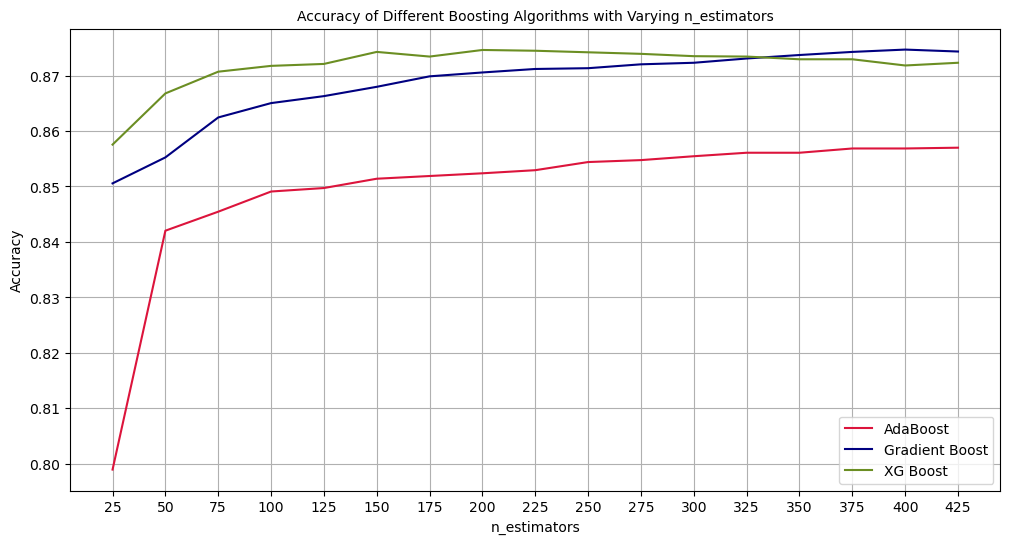

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(estimator_vals, accuracy_ada, color='crimson', label='AdaBoost')
plt.plot(estimator_vals, accuracy_gb, color='navy', label='Gradient Boost')
plt.plot(estimator_vals, accuracy_xgb, color='olivedrab', label='XG Boost')

# Display axes and title
plt.title("Accuracy of Different Boosting Algorithms with Varying n_estimators", fontsize=10)
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.xticks(np.arange(25, 426, 25))
plt.grid(True)

plt.legend()
plt.show()

In [ ]:
max_index1 = np.argmax(accuracy_ada)
best_est1 = estimator_vals[max_index1]
print("Ada Boost:", best_est1)

max_index2 = np.argmax(accuracy_gb)
best_est2 = estimator_vals[max_index2]
print("Gradient Boost:", best_est2)

max_index3 = np.argmax(accuracy_xgb)
best_est3 = estimator_vals[max_index3]
print("XG Boost:", best_est3)

Ada Boost: 425
Gradient Boost: 400
XG Boost: 200


In [ ]:
rate_vals = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
accuracy_ada2 = []
accuracy_gb2 = []
accuracy_xgb2 = []

for r in rate_vals:
    adaboost = AdaBoostClassifier(n_estimators=100, learning_rate=r, random_state=123)
    adaboost.fit(X_train, y_train)
    y_pred_ada = adaboost.predict(X_test)
    accuracy_ada2.append(accuracy_score(y_test, y_pred_ada))

    gboost = GradientBoostingClassifier(n_estimators=175, learning_rate=r, random_state=123)
    gboost.fit(X_train, y_train)
    y_pred_gb = gboost.predict(X_test)
    accuracy_gb2.append(accuracy_score(y_test, y_pred_gb))

    
    xgboost = xgb.XGBClassifier(n_estimators=150, learning_rate=r, random_state=123)
    xgboost.fit(X_train, y_train)
    y_pred_xgb = xgboost.predict(X_test)
    accuracy_xgb2.append(accuracy_score(y_test, y_pred_xgb))
    

print(accuracy_ada2)
print(accuracy_gb2)
print(accuracy_xgb2)

[0.849093581577658, 0.8523832855043046, 0.8574928256456918, 0.8577728004479597, 0.8591726744592987, 0.858612724854763, 0.8595226429621334, 0.860012598866102, 0.8609225169734724, 0.8623923846853783]
[0.8698817106460418, 0.8731014208721215, 0.8714215720585148, 0.8709316161545461, 0.8700216980471758, 0.8703016728494436, 0.8693917547420732, 0.8679218870301673, 0.8672219500244978, 0.862882340589347]
[0.8742913137817596, 0.8715615594596486, 0.8679218870301673, 0.8682018618324351, 0.8644921957023868, 0.8599426051655351, 0.8574928256456918, 0.8508434240918318, 0.8554630083292504, 0.8530132288094071]


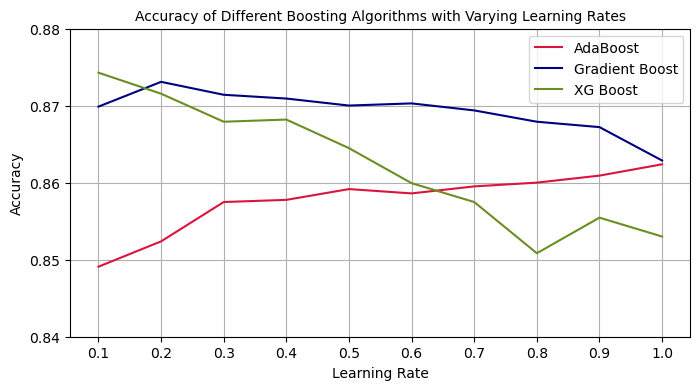

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(rate_vals, accuracy_ada2, color='crimson', label='AdaBoost')
plt.plot(rate_vals, accuracy_gb2, color='navy', label='Gradient Boost')
plt.plot(rate_vals, accuracy_xgb2, color='olivedrab', label='XG Boost')

# Display axes and title
plt.title("Accuracy of Different Boosting Algorithms with Varying Learning Rates", fontsize=10)
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy")
plt.xticks(np.arange(0.1, 1.1, 0.1))
plt.yticks(np.arange(0.84, 0.88, 0.01))
plt.grid(True)

plt.legend()
plt.show()

In [ ]:
max_index1 = np.argmax(accuracy_ada2)
best_rate1 = rate_vals[max_index1]
print("Ada Boost:", best_rate1)

max_index2 = np.argmax(accuracy_gb2)
best_rate2 = rate_vals[max_index2]
print("Gradient Boost:", best_rate2)

max_index3 = np.argmax(accuracy_xgb2)
best_rate3 = rate_vals[max_index3]
print("XG Boost:", best_rate3)

Ada Boost: 1.0
Gradient Boost: 0.2
XG Boost: 0.1
